Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

In [184]:
!pip install Augmentor pathlib2 keras-tuner

### Importing all the important libraries

In [185]:
import Augmentor
from IPython import get_ipython
from IPython.display import display

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
import sys
from pathlib2 import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.regularizers import l2
import kerastuner as kt
from kerastuner import HyperModel, RandomSearch, Hyperband, BayesianOptimization
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomTranslation, RandomZoom
from tensorflow.python.client import device_lib
from glob import glob

In [186]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [187]:
!unzip /content/gdrive/MyDrive/Assignment/CNN_assignment.zip

Archive:  /content/gdrive/MyDrive/Assignment/CNN_assignment.zip
replace Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [190]:
def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU' or x.device_type == 'CPU']


get_available_devices()


['/device:CPU:0', '/device:GPU:0']

In [191]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [192]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166
root_folder = Path().resolve()
root_folder

PosixPath('/content')

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [193]:
root_folder = Path().resolve()
images_path = root_folder/"gdrive"/"MyDrive"/"Assignment" / "Skin cancer ISIC The International Skin Imaging Collaboration"
images_path

PosixPath('/content/gdrive/MyDrive/Assignment/Skin cancer ISIC The International Skin Imaging Collaboration')

In [194]:

# Defining the path for train and test images
# Todo: Update the paths of the train and test dataset
data_dir_train = images_path / "Train"
data_dir_test = images_path / "Test"

In [195]:

train_image_file_names = list(data_dir_train.glob('*/*.jpg'))
image_count_train = len(train_image_file_names)
print(image_count_train)
test_image_file_names = list(data_dir_test.glob('*/*.jpg'))
image_count_test = len(test_image_file_names)
print(image_count_test)

0
0


In [196]:
root_folder = Path().resolve()
images_path = root_folder / "Skin cancer ISIC The International Skin Imaging Collaboration"
images_path

PosixPath('/content/Skin cancer ISIC The International Skin Imaging Collaboration')

In [197]:
# Defining the path for train and test images
# Todo: Update the paths of the train and test dataset
data_dir_train = images_path / "Train"
data_dir_test = images_path / "Test"

In [198]:
train_image_file_names = list(data_dir_train.glob('*/*.jpg'))
image_count_train = len(train_image_file_names)
print(image_count_train)
test_image_file_names = list(data_dir_test.glob('*/*.jpg'))
image_count_test = len(test_image_file_names)
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [199]:
batch_size = 32
img_height = 180
img_width = 180
SEED = 123
image_size = (img_height, img_width)
epochs = 20


Use 80% of the images for training, and 20% for validation.

In [200]:

# Write your train dataset here
# Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
# Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = image_dataset_from_directory(data_dir_train, seed=SEED, image_size=image_size, batch_size=batch_size, validation_split=0.2, subset="training", )
train_ds

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [201]:

# Write your validation dataset here
# Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
# Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = image_dataset_from_directory(data_dir_test, seed=SEED, image_size=image_size, batch_size=batch_size, subset="validation", validation_split=0.2)


Found 118 files belonging to 9 classes.
Using 23 files for validation.


In [202]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

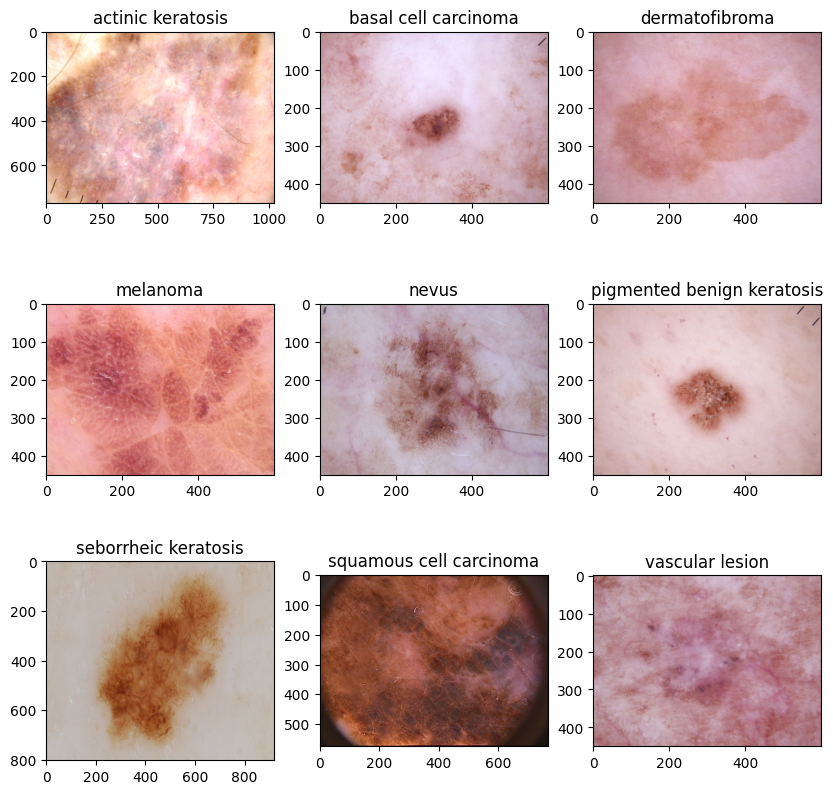

In [203]:


fig = plt.figure(figsize=(10, 10))
for i in range(len(class_names)):
    ax = plt.subplot(3, 3, i + 1)
    class_name = class_names[i]
    img_dir = data_dir_train / class_name
    img_num = np.random.randint(image_count_train)
    im = plt.imread(str(train_image_file_names[img_num]))
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [204]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [205]:
#  Rescaling is used as part of model

input_shape = (img_height, img_width, 3)
num_classes = len(class_names)


def build_model(input_shape, num_classes):
    model = Sequential([
        #  Rescaling : to bring values between [0,1]
        Rescaling(1./255, input_shape=input_shape),
        Conv2D(16, 3, padding='same', activation='relu'),
        MaxPooling2D(),
        Conv2D(32, 3, padding='same', activation='relu'),
        MaxPooling2D(),
        Conv2D(64, 3, padding='same', activation='relu'),
        MaxPooling2D(),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(num_classes)
    ])
    return model


model = build_model(input_shape=(img_height, img_width, 3), num_classes=len(class_names))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [206]:
# Todo, choose an appropriate optimizer and loss function


def complie_model(model):
    """Compiles model for image classification with adam optimizer, SparseCategoricalCrossentropy and accuracy

    Args:
        model ([Any]): Sequential model

    Returns:
        Any: complied Model
    """
    model.compile(optimizer="rmsprop",  # adam gave similar results, however with sgd model remained underfit
                  loss=SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    return model


def train_model(model, train_ds, val_ds, epochs: int = 20):
    """Trains CNN model

    Args:
        model ([Any]): Compiled model
        train_ds ([Any]): Training dataset
        val_ds ([Any]): Validation dataset
        epochs ([int]): Number of epochs

    Returns:
        [Any]: Training history
    """
    history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)
    return history


def compile_and_train_model(model, train_ds, val_ds, epochs):
    """Compiles model for image classification with sgd optimizer, SparseCategoricalCrossentropy and accuracy, display model summary and Trains CNN model

    Args:
        model ([Any]): Compiled model
        train_ds ([Any]): Training dataset
        val_ds ([Any]): Validation dataset
        epochs ([int]): Number of epochs

    Returns:
        [Any]: Training history
    """
    model = complie_model(model)
    display(model.summary())
    history = train_model(model, train_ds, val_ds, epochs)
    return history, model


In [207]:
history, model = compile_and_train_model(model, train_ds, val_ds, epochs)

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_18 (Rescaling)             │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_103 (Conv2D)                  │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_103 (MaxPooling2D)     │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_104 (Conv2D)                  │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_104 (MaxPooling2D)     │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_105 (Conv2D)                  │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_105 (MaxPooling2D)     │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_18 (Flatten)                 │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_36 (Dense)                     │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_37 (Dense)                     │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

None

Epoch 1/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 26s 38ms/step - accuracy: 0.2051 - loss: 2.3522 - val_accuracy: 0.3913 - val_loss: 1.8014
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.3893 - loss: 1.6272 - val_accuracy: 0.2174 - val_loss: 2.3960
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.4639 - loss: 1.4510 - val_accuracy: 0.3478 - val_loss: 2.8408
Epoch 4/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.5429 - loss: 1.2677 - val_accuracy: 0.1304 - val_loss: 2.7224
Epoch 5/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.6062 - loss: 1.0657 - val_accuracy: 0.1304 - val_loss: 3.6384
Epoch 6/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.6948 - loss: 0.8900 - val_accuracy: 0.2174 - val_loss: 3.2239
Epoch 7/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.7469 - loss: 0.7355 - val_accuracy: 0.2609 - val_loss: 4.4019
Epoch 8/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.7847 - loss: 0.6307 - val_acc

In [208]:
# View the summary of all layers
model.summary()

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_18 (Rescaling)             │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_103 (Conv2D)                  │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_103 (MaxPooling2D)     │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_104 (Conv2D)                  │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_104 (MaxPooling2D)     │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_105 (Conv2D)                  │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_105 (MaxPooling2D)     │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_18 (Flatten)                 │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_36 (Dense)                     │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_37 (Dense)                     │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,979,604 (30.44 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,989,803 (15.22 MB)

### Train the model

In [209]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9438 - loss: 0.1505 - val_accuracy: 0.2609 - val_loss: 8.5529
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9478 - loss: 0.1485 - val_accuracy: 0.2174 - val_loss: 7.3483
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9520 - loss: 0.1364 - val_accuracy: 0.2609 - val_loss: 6.5098
Epoch 4/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.9509 - loss: 0.1354 - val_accuracy: 0.2609 - val_loss: 7.9937
Epoch 5/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9543 - loss: 0.1332 - val_accuracy: 0.2609 - val_loss: 8.1108
Epoch 6/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9496 - loss: 0.1327 - val_accuracy: 0.1304 - val_loss: 8.8026
Epoch 7/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9590 - loss: 0.1124 - val_accuracy: 0.2174 - val_loss: 7.9822
Epoch 8/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.9553 - loss: 0.1136 - val_accu

### Visualizing training results

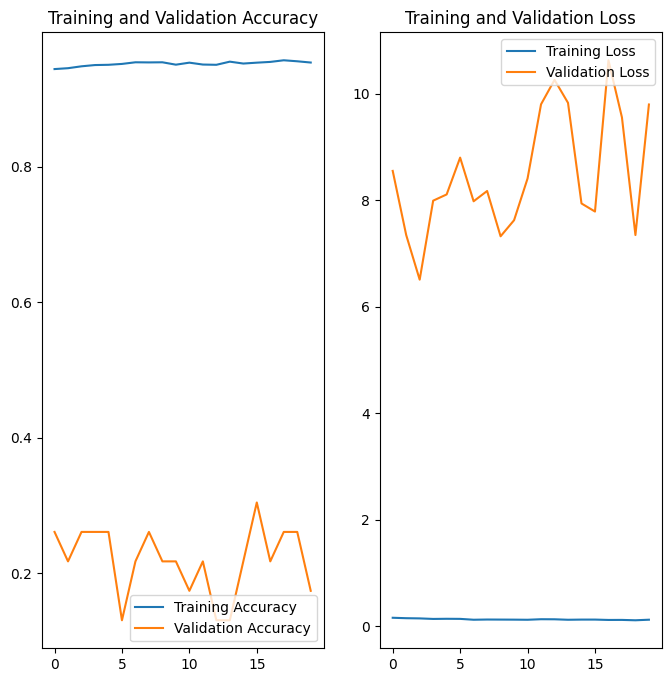

In [210]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

We could draw below conclusions - rmsprop and adam optimizers gave similar results (overfitting the model) - however with sgd model remained underfit - For this experimentation I am going with rmsprop optimizer - As we can see that both training and validations accuracy are apart from each other, while training accuracy touching 90%, validation accuracy is fluctuating between 20-30% this shows that model is kind of overfit

In [211]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here
# Your code goes here
data_augmentation = keras.Sequential(
    [
        RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
        RandomRotation(0.1),
        RandomZoom(0.1, 0.1),
        RandomTranslation(0.1, 0.1)
    ]
)

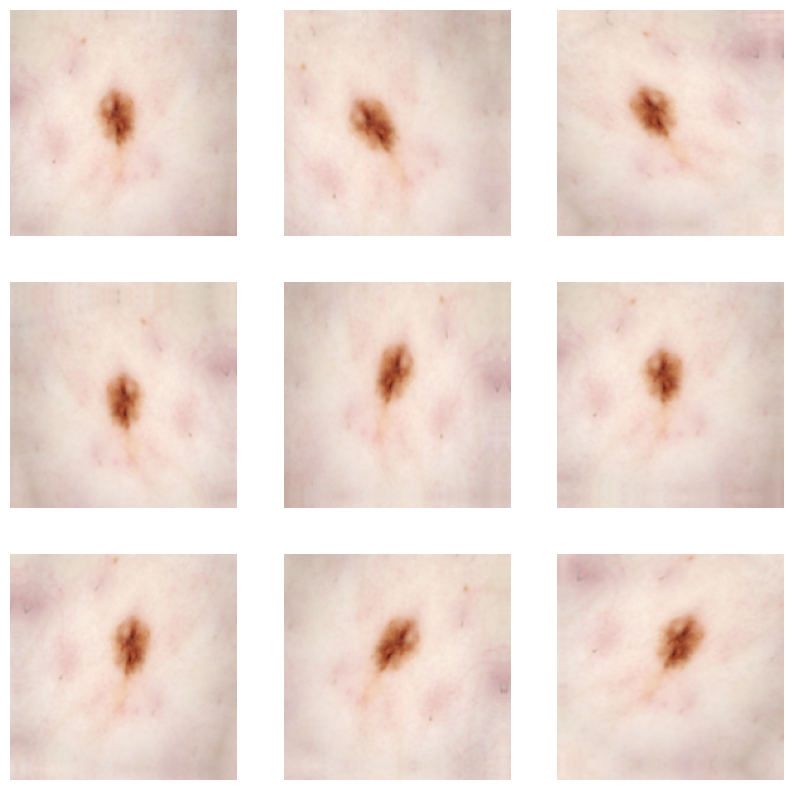

In [212]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [213]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
model = Sequential([
    data_augmentation,
    Rescaling(1./255),
    Conv2D(16, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes)
])


### Compiling the model

In [214]:
## Your code goes here
history, model = compile_and_train_model(model, train_ds, val_ds, epochs)


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_20 (Sequential)           │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_19 (Rescaling)             │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_106 (Conv2D)                  │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_106 (MaxPooling2D)     │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_107 (Conv2D)                  │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_107 (MaxPooling2D)     │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_108 (Conv2D)                  │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_108 (MaxPooling2D)     │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_77 (Dropout)                 │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_19 (Flatten)                 │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_38 (Dense)                     │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_39 (Dense)                     │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

None

Epoch 1/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.1894 - loss: 2.5354 - val_accuracy: 0.1739 - val_loss: 2.3715
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.3760 - loss: 1.6918 - val_accuracy: 0.3913 - val_loss: 1.7083
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.4067 - loss: 1.5663 - val_accuracy: 0.1739 - val_loss: 1.8928
Epoch 4/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.4456 - loss: 1.4603 - val_accuracy: 0.3043 - val_loss: 1.9668
Epoch 5/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.4497 - loss: 1.4449 - val_accuracy: 0.2174 - val_loss: 2.2177
Epoch 6/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.4624 - loss: 1.4145 - val_accuracy: 0.3043 - val_loss: 2.6331
Epoch 7/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.4818 - loss: 1.3604 - val_accuracy: 0.3478 - val_loss: 1.8953
Epoch 8/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.4960 - loss: 1.3291 - val_accu

### Training the model

### Visualizing the results

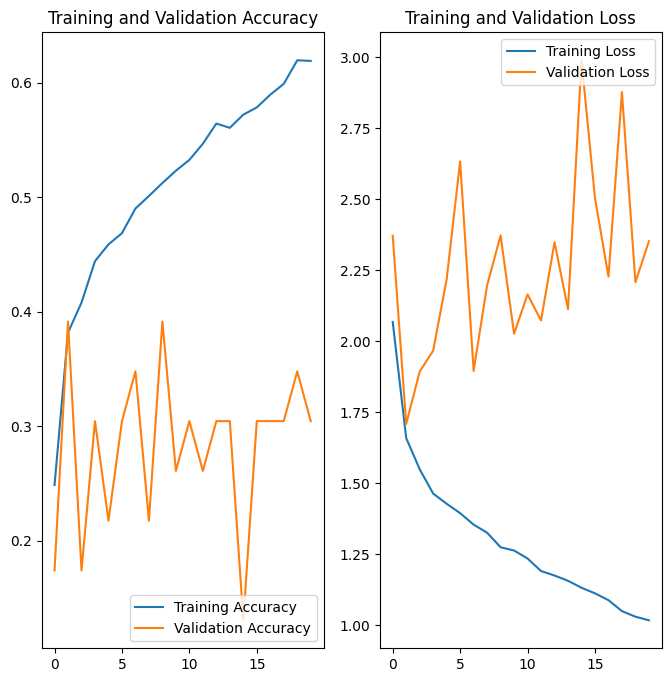

In [215]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

**In both plots we can see that there are similar trend however there are below things which we could see **

There is a bit more stability in validation accuracy, most of time it remained towards 30s
The gap between Training and validation accuracy is significantly lower than previous experiment
Validation accuracy with augmented data is a bit in lower range
Model is towards underfit now as even training accuracy now could reaching to 60%

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

,Class,Image Count
0,vascular lesion,139
1,dermatofibroma,500
2,seborrheic keratosis,95
3,basal cell carcinoma,500
4,actinic keratosis,77
5,pigmented benign keratosis,500
6,squamous cell carcinoma,376
7,melanoma,500
8,nevus,114
9,output,500


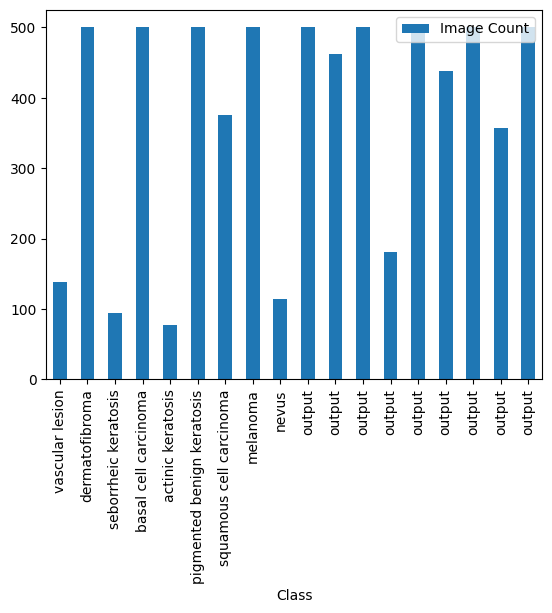

In [216]:
## Your code goes here.
all_dirs = []
file_counts = []
for base, dirs, files in os.walk(data_dir_train):
    for d in dirs:
        all_dirs.append(d)
    if not base.endswith("Train"):
        file_counts.append(len([f for f in files]))
file_count_df = pd.DataFrame(zip(all_dirs, file_counts), columns=["Class", "Image Count"])
display(file_count_df)
file_count_df.plot.bar(x='Class', y='Image Count')
plt.show()


In [217]:
file_count_df.sort_values(by="Image Count", ascending=False)

,Class,Image Count
1,dermatofibroma,500
3,basal cell carcinoma,500
15,output,500
5,pigmented benign keratosis,500
9,output,500
7,melanoma,500
13,output,500
17,output,500
11,output,500
10,output,462


#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
        seborrheic keratosis with count 77
#### - Which classes dominate the data in terms proportionate number of samples?
        pigmented benign keratosis with count 462

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [218]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [219]:
for i in class_names:
    p = Augmentor.Pipeline(data_dir_train / i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    # p.zoom(probability=0.3, min_factor=1.1, max_factor=1.6)
    p.sample(500)

Initialised with 114 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C00AD2EFED0>: 100%|██████████| 500/500 [00:18<00:00, 27.48 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7C00AC343AD0>: 100%|██████████| 500/500 [00:17<00:00, 28.67 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C00ABBA8690>: 100%|██████████| 500/500 [00:13<00:00, 36.52 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=961x649 at 0x7C00ABBAC190>: 100%|██████████| 500/500 [01:14<00:00,  6.72 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=3072x2304 at 0x7C00AC21DCD0>: 100%|██████████| 500/500 [01:14<00:00,  6.67 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C00ABBA1B50>: 100%|██████████| 500/500 [00:15<00:00, 31.92 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7C00ACCAD790>: 100%|██████████| 500/500 [00:31<00:00, 15.63 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7C00AB898C50>: 100%|██████████| 500/500 [00:13<00:00, 36.78 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7C00AC337790>: 100%|██████████| 500/500 [00:13<00:00, 37.45 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [220]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

9000


### Lets see the distribution of augmented data after adding new images to the original training data.

In [222]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list[:5]

['/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0029877.jpg_ef4d390c-b6ad-44e9-b995-fd6cc9bbc85f.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0033969.jpg_66a5caa2-e019-4ca2-97dc-e9c9cbfdca0e.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0029099.jpg_9ccdc330-a6c8-4726-a49b-b9893805c4ad.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0033608.jpg_37610e99-6632-4aeb-a8de-3ed48e1fcf51.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0031759.jpg_7ff5f30f-bfcc-4388-b2ca-857543341f9d.jpg']

In [223]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',


In [227]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*', 'output', '*.jpg'))]
path_list[:5]

['/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0029877.jpg_ef4d390c-b6ad-44e9-b995-fd6cc9bbc85f.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0033969.jpg_66a5caa2-e019-4ca2-97dc-e9c9cbfdca0e.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0029099.jpg_9ccdc330-a6c8-4726-a49b-b9893805c4ad.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0033608.jpg_37610e99-6632-4aeb-a8de-3ed48e1fcf51.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0031759.jpg_7ff5f30f-bfcc-4388-b2ca-857543341f9d.jpg']

In [229]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [243]:
original_df = pd.DataFrame([(str(p), str(p.parent).split("\\")[-1]) for p in train_image_file_names], columns=['Path', 'Label'])
original_df.head()


,Path,Label
0,/content/Skin cancer ISIC The International Sk...,/content/Skin cancer ISIC The International Sk...
1,/content/Skin cancer ISIC The International Sk...,/content/Skin cancer ISIC The International Sk...
2,/content/Skin cancer ISIC The International Sk...,/content/Skin cancer ISIC The International Sk...
3,/content/Skin cancer ISIC The International Sk...,/content/Skin cancer ISIC The International Sk...
4,/content/Skin cancer ISIC The International Sk...,/content/Skin cancer ISIC The International Sk...


In [247]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()), columns=['Path', 'Label'])
new_df = pd.concat([original_df, df2], ignore_index=True)  # Use pd.concat()


In [252]:
new_df['Label'].value_counts()

,count
Label,
melanoma,1000
vascular lesion,1000
nevus,1000
basal cell carcinoma,1000
squamous cell carcinoma,1000
pigmented benign keratosis,1000
actinic keratosis,1000
dermatofibroma,1000
seborrheic keratosis,1000


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [264]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [267]:
# Lets make new traininf location
new_train_path = images_path/"AugTrain"
new_train_path_str = str(new_train_path)
if os.path.exists(new_train_path_str):
    shutil.rmtree(new_train_path_str)
os.mkdir(new_train_path_str)

In [269]:
for c in new_df['Label'].unique():
    class_path = os.path.join(new_train_path, c)  # Use os.path.join for correct path handling

    if not os.path.exists(class_path):
        os.makedirs(class_path, exist_ok=True)  # Creates directory if it doesn't exist

    for f in new_df[new_df['Label'] == c]['Path']:
        destination_file = os.path.join(class_path, os.path.basename(f))  # Construct full destination path

        if os.path.abspath(f) != os.path.abspath(destination_file):  # ✅ Check if source and destination are different
            shutil.copy(f, destination_file)  # Copy only if they are different


In [272]:
data_dir_train = new_train_path  # "path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=SEED,
    validation_split=validation_split,
    subset='training',  # Todo choose the correct parameter value, so that only training data is refereed to,
    image_size=image_size,
    batch_size=batch_size)

Found 9000 files belonging to 9 classes.
Using 7200 files for training.


#### **Todo:** Create a validation dataset

In [273]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=SEED,
    validation_split=validation_split,
    subset='validation',  # Todo choose the correct parameter value, so that only validation data is refereed to,
    image_size=image_size,
    batch_size=batch_size)

Found 9000 files belonging to 9 classes.
Using 1800 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [274]:
## your code goes here
def build_model(input_shape, num_classes):
    model = Sequential([
        #  Rescaling : to bring values between [0,1]
        Rescaling(1./255, input_shape=input_shape),
        Conv2D(32, 3, padding='same', activation='relu'),
        MaxPooling2D(),
        Conv2D(64, 3, padding='same', activation='relu'),
        MaxPooling2D(),
        Dropout(0.2),
        Conv2D(64, 3, padding='same', activation='relu'),
        MaxPooling2D(),
        Dropout(0.22),
        Conv2D(128, 3, padding='same', activation='relu'),
        MaxPooling2D(),
        Dropout(0.2),
        Conv2D(256, 3, activation='relu'),
        MaxPooling2D(),
        Dropout(0.2),
        Conv2D(128, 3, activation='relu'),
        MaxPooling2D(),
        Dropout(0.2),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(num_classes)
    ])
    return model


model = build_model(input_shape=input_shape, num_classes=len(class_names))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [275]:
## your code goes here
model = complie_model(model)
display(model.summary())

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_20 (Rescaling)             │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_109 (Conv2D)                  │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_109 (MaxPooling2D)     │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_110 (Conv2D)                  │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_110 (MaxPooling2D)     │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_78 (Dropout)                 │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_111 (Conv2D)                  │ (None, 45, 45, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_111 (MaxPooling2D)     │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_79 (Dropout)                 │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_112 (Conv2D)                  │ (None, 22, 22, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_112 (MaxPooling2D)     │ (None, 11, 11, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_80 (Dropout)                 │ (None, 11, 11, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_113 (Conv2D)                  │ (None, 9, 9, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_113 (MaxPooling2D)     │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_81 (Dropout)                 │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_114 (Conv2D)                  │ (None, 2, 2, 128)           │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_114 (MaxPooling2D)     │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_82 (Dropout)                 │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_20 (Flatten)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_40 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_41 (Dense)                     │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 738,057 (2.82 MB)

 Trainable params: 738,057 (2.82 MB)

 Non-trainable params: 0 (0.00 B)

None

#### **Todo:**  Train your model

In [276]:
epochs = 30
# Your code goes here, use 50 epochs.
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5),
    tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5')
]
# history = train_model(model, train_ds, val_ds, epochs, callbacks=callbacks)
history = train_model(model, train_ds, val_ds, epochs)

Epoch 1/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 34s 119ms/step - accuracy: 0.1214 - loss: 2.2130 - val_accuracy: 0.1367 - val_loss: 2.3114
Epoch 2/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 31s 96ms/step - accuracy: 0.2542 - loss: 1.9340 - val_accuracy: 0.3483 - val_loss: 1.5973
Epoch 3/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 41s 96ms/step - accuracy: 0.3603 - loss: 1.6760 - val_accuracy: 0.3889 - val_loss: 1.5468
Epoch 4/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 42s 99ms/step - accuracy: 0.3942 - loss: 1.5633 - val_accuracy: 0.3817 - val_loss: 1.5264
Epoch 5/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 41s 101ms/step - accuracy: 0.4288 - loss: 1.4871 - val_accuracy: 0.4206 - val_loss: 1.5176
Epoch 6/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 22s 96ms/step - accuracy: 0.4595 - loss: 1.4307 - val_accuracy: 0.4867 - val_loss: 1.3450
Epoch 7/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 20s 88ms/step - accuracy: 0.4798 - loss: 1.3564 - val_accuracy: 0.5172 - val_loss: 1.2515
Epoch 8/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 22s 97ms/step - accuracy: 0.5293 - loss: 1.2766 

#### **Todo:**  Visualize the model results

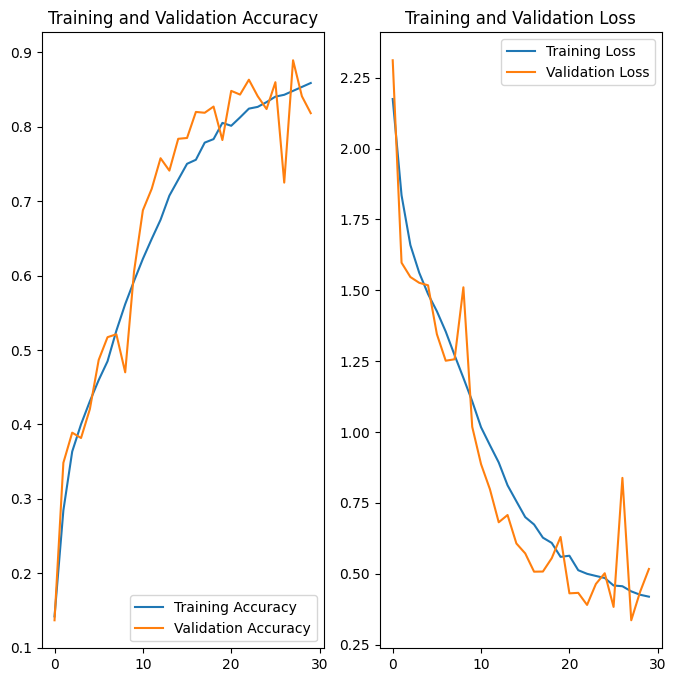

In [277]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



I ran the model with multiple mentioned configurations, Observations are below:

Configuration	Observations
Simple Model	Even simple model with augmenter performed much better than without augmenter that means More the data we'll have better model
With one extra layer	Added one extra layer as validation accuracy kept fluctuating
With Dropout	Added one drop outlayer with 0.2 and found that validation accuracy was a bit stabilized
Added more layers and dropputs	Training of network became much stable accuracy and validation accuracy followed tightly together, so decided to increase the epochs and observe
With Callback	Added two callbacks for saving the model and early stopping, model did stop on epoch number and with validation accuracy
Found that with 70 epochs accuracy and validation accuracy settled around 85% and 87% respectively, model looked fairly stable so stopped training